# Inference with Trained ANN Potentials

This notebook demonstrates how to use trained neural network potentials for making predictions (inference) on new atomic structures. We'll cover:

1. Loading pre-trained potentials
2. Basic energy predictions
3. Predicting forces
4. Working with prediction results
5. Custom prediction configurations
6. Batch predictions

**Note: This requires the ænet binaries to be correctly installed and configured.**

## 1. Loading Pre-trained Potentials

The easiest way to use an existing trained potential is with the `from_files()` factory method. This creates an `ANNPotential` instance configured for prediction-only use.

In [1]:
import glob
from aenet.mlip import ANNPotential, PredictionConfig

# Load pre-trained potentials (using test data as example)
# In practice, these would be your trained .nn files
potential_paths = {
    'Ti': './nn-TiO2/Ti.nn.ascii',
    'O': './nn-TiO2/O.nn.ascii'
}

# Set format at load time - it will be remembered for all predictions
potential = ANNPotential.from_files(potential_paths, potential_format='ascii')
print(f"Loaded potential for {potential.num_types} atomic species: {potential.atom_types}")

Loaded potential for 2 atomic species: ['Ti', 'O']


## 2. Basic Energy Predictions

The `predict()` method accepts either file paths to XSF structures or `AtomicStructure` objects. Let's start with file paths:

In [2]:
# Get some structures to predict
xsf_files = sorted(glob.glob('./xsf-TiO2/*.xsf'))[:3]

# Run predictions
results = potential.predict(
    xsf_files, 
    # workdir='run-predict'  # uncomment to inspect files
)

results

PredictOut with 3 structure(s)  
  Structure 0: 23 atoms, E_tot = -19517.166 eV = -848.572 eV/atom  
  Structure 1: 46 atoms, E_tot = -39038.491 eV = -848.663 eV/atom  
  Structure 2: 23 atoms, E_tot = -19517.813 eV = -848.601 eV/atom  


## 3. Predicting Forces

Forces can be computed by setting `eval_forces=True`. This is useful for molecular dynamics or geometry optimization.

In [3]:
# set additional parameters with PredictionConfig
config = PredictionConfig(verbosity=0)

# run prediction
results_with_forces = potential.predict(
    xsf_files[:3],
    eval_forces=True,
    config=config,
    # workdir='run-predict'  # uncomment to preserve files
)

print("Predictions with forces:")
for i in range(results_with_forces.num_structures):
    n_atoms = results_with_forces.num_atoms(i)
    print(f"\nStructure {i+1}: {n_atoms} atoms")
    print(f"  Total energy: {results_with_forces.total_energy[i]/n_atoms:.6f} eV/atom")
    print(f"  Cohesive energy: {results_with_forces.cohesive_energy[i]/n_atoms:.6f} eV/atom")
    print(f"  Forces shape: {results_with_forces.forces[i].shape}")
    
    # Show force magnitudes
    import numpy as np
    force_mags = np.linalg.norm(results_with_forces.forces[i], axis=1)
    print(f"  Max force magnitude: {force_mags.max():.6f} eV/Å")
    print(f"  Mean force magnitude: {force_mags.mean():.6f} eV/Å")

Predictions with forces:

Structure 1: 23 atoms
  Total energy: -848.572425 eV/atom
  Cohesive energy: -8.381844 eV/atom
  Forces shape: (23, 3)
  Max force magnitude: 3.452977 eV/Å
  Mean force magnitude: 1.489197 eV/Å

Structure 2: 46 atoms
  Total energy: -848.662852 eV/atom
  Cohesive energy: -8.472271 eV/atom
  Forces shape: (46, 3)
  Max force magnitude: 0.485914 eV/Å
  Mean force magnitude: 0.100886 eV/Å

Structure 3: 23 atoms
  Total energy: -848.600553 eV/atom
  Cohesive energy: -8.409972 eV/atom
  Forces shape: (23, 3)
  Max force magnitude: 3.334040 eV/Å
  Mean force magnitude: 1.496674 eV/Å


## 4. Working with Prediction Results

The `PredictOut` object provides convenient access to results. You can also convert predictions back to `AtomicStructure` objects with energies and forces attached:

In [4]:
# Convert results to AtomicStructure objects
structures_with_predictions = results_with_forces.to_structures()
print(structures_with_predictions[0])


 Composition        : O15 Ti8
 Number of atoms    : 23
 Number of species  : 2
 Total energy       : -19517.16578343 eV
 Geometric center   : 2.50272756 2.74034874 4.83094239 (Ang)
 Unit cell volume   : 264.131 Ang^3
 Cell parameters    : 5.17600016 5.50899976 9.26300011 90.00000000 90.00000000 90.00000000
 Areas (ab, bc, ac) : 28.51458364 47.94529005 51.02986538 Ang^2

 Lattice vectors

 a1 =      5.17600016       0.00000000       0.00000000
 a2 =      0.00000000       5.50899976       0.00000000
 a3 =      0.00000000       0.00000000       9.26300011

 Cartesian coordinates

 Ti        1.91782900       3.21092298       3.45760499
 Ti        3.39163500       2.30872800       5.85770899
 Ti        4.25105701       2.03699099       1.57059601
 Ti        0.73274301       3.38245801       7.85142201
 Ti        1.93979700       0.10798100       1.36979399
 Ti        3.16560398       5.29707099       7.87096802
 Ti        0.83160300       0.59646801       5.89120602
 Ti        4.63367799  

## 5. Custom Prediction Configurations

The `PredictionConfig` class allows you to customize various aspects of the prediction:

In [5]:
# Create a custom configuration
# Format is already set from from_files(), but we can override other options
custom_config = PredictionConfig(
    verbosity=2,                    # High verbosity (0=low, 1=normal, 2=high)
    timing=True,                    # Enable timing output
    print_atomic_energies=True,     # Print per-atom energies
    debug=False                     # Debug mode (off for now)
)

# Run prediction with custom config
results_custom = potential.predict(
    xsf_files[:2],
    eval_forces=True,
    config=custom_config,
    workdir='run-predict'
)

print(f"Completed predictions with custom configuration")
print(f"Check run-predict/predict.out for detailed output")

Completed predictions with custom configuration
Check run-predict/predict.out for detailed output


In [6]:
results_custom.atom_energies

[array([-1612.844133, -1613.196937, -1613.116053, -1613.320145,
        -1612.841942, -1612.864025, -1612.85179 , -1612.686844,
         -440.549049,  -440.762753,  -440.848945,  -440.655441,
         -440.977814,  -440.472212,  -441.026056,  -441.07824 ,
         -440.679728,  -441.064339,  -440.965074,  -441.209925,
         -440.996532,  -441.064218,  -441.093591]),
 array([-1612.81304 , -1612.91969 , -1612.91969 , -1612.074184,
        -1612.81304 , -1612.91969 , -1612.91969 , -1612.074184,
        -1612.86395 , -1612.540606, -1612.788488, -1612.86395 ,
        -1612.86395 , -1612.788488, -1612.540606, -1612.86395 ,
         -441.079246,  -441.22995 ,  -441.22995 ,  -441.274972,
         -441.079246,  -441.22995 ,  -441.22995 ,  -441.274972,
         -441.079246,  -441.22995 ,  -441.229949,  -441.274971,
         -441.079246,  -441.229949,  -441.22995 ,  -441.274971,
         -441.259921,  -441.098068,  -441.098068,  -441.304643,
         -441.112299,  -440.980381,  -440.980381,  -

## 6. Batch Predictions

You can efficiently predict energies for many structures at once:

Running batch prediction on 100 structures...

Batch prediction complete!
Predicted 100 structures


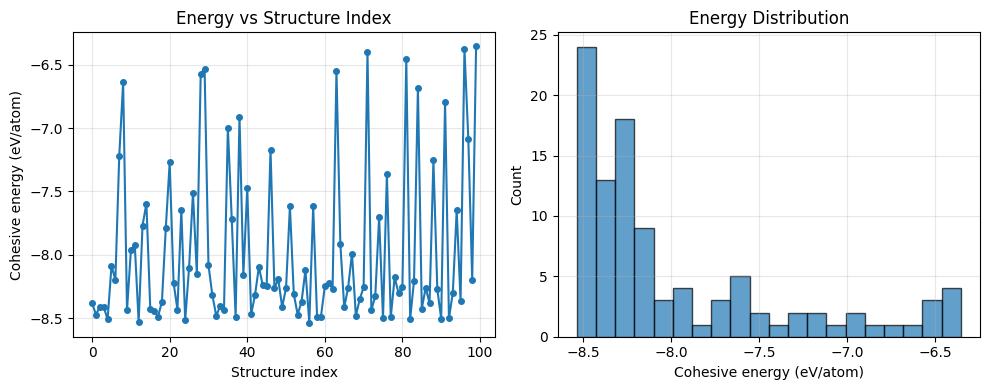


Energy statistics:
  Mean: -7.976554 eV/atom
  Std:  0.617136 eV/atom
  Min:  -8.537718 eV/atom
  Max:  -6.352595 eV/atom


In [7]:
# Get all available structures
all_xsf_files = sorted(glob.glob('./xsf-TiO2/*.xsf'))
print(f"Running batch prediction on {len(all_xsf_files)} structures...")

batch_results = potential.predict(
    all_xsf_files,
    eval_forces=False,  # Faster without forces
    config=PredictionConfig(verbosity=0),  # Format remembered from load
    # workdir='run-predict'
)

print(f"\nBatch prediction complete!")
print(f"Predicted {batch_results.num_structures} structures")

# Analyze the energy distribution
import numpy as np
import matplotlib.pyplot as plt

energies = np.array(batch_results.cohesive_energy_per_atom)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(energies, 'o-', markersize=4)
plt.xlabel('Structure index')
plt.ylabel('Cohesive energy (eV/atom)')
plt.title('Energy vs Structure Index')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(energies, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Cohesive energy (eV/atom)')
plt.ylabel('Count')
plt.title('Energy Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEnergy statistics:")
print(f"  Mean: {energies.mean():.6f} eV/atom")
print(f"  Std:  {energies.std():.6f} eV/atom")
print(f"  Min:  {energies.min():.6f} eV/atom")
print(f"  Max:  {energies.max():.6f} eV/atom")

## 7. Predicting from AtomicStructure Objects

You can also pass `AtomicStructure` objects directly instead of file paths:

In [10]:
from aenet.io.structure import read as read_structure
import glob

# Load structures as AtomicStructure objects
xsf_files = glob.glob('./xsf-TiO2/*.xsf')
structures = [read_structure(f) for f in xsf_files[:3]]
print(f"Loaded {len(structures)} AtomicStructure objects\n")

# Predict directly from objects
# The predict() method will automatically create temporary XSF files
results_from_objects = potential.predict(
    structures,
    eval_forces=True,
    # workdir='run-predict'
)

results_from_objects

Loaded 3 AtomicStructure objects



PredictOut with 3 structure(s)  
  Structure 0: 24 atoms, E_tot = -19960.947 eV = -831.706 eV/atom  
  Structure 1: 24 atoms, E_tot = -19954.192 eV = -831.425 eV/atom  
  Structure 2: 6 atoms, E_tot = -4982.752 eV = -830.459 eV/atom  


## 8. Using Predictions After Training

If you just finished training a potential in the same session, you can use it directly without `from_files()`:

In [ ]:
# After training (example workflow)
# arch = {'Ti': [(10, 'tanh'), (10, 'tanh')], 'O': [(10, 'tanh'), (10, 'tanh')]}
# potential = ANNPotential(arch)
# potential.train(trnset_file='data.train', ...)

# Now predict immediately - potential paths are automatically stored
# results = potential.predict(structures, eval_forces=True)

print("After training, the potential automatically knows where the .nn files are!")
print("You can predict immediately without needing from_files().")